In [ ]:
#RNN with attention

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,LSTM,GRU,SimpleRNN,Input,Dropout,TimeDistributed,RepeatVector,dot,BatchNormalization,concatenate,multiply,Activation
from keras.layers.embeddings import Embedding
from keras.layers import Layer
from keras.preprocessing import sequence
# updated as tensorflow.keras
from tensorflow.keras.optimizers import Adam,Adadelta,Nadam,SGD
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
class AttentionModel(Layer):
  def __init__(self, units):
    super(AttentionModel, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    
    attention_wts = tf.nn.softmax(score, axis=1)
    context_vector = tf.reduce_sum((attention_wts * values), axis=1)

    return context_vector, attention_wts

In [ ]:
class Encoder(Model):
  def __init__(self,cell,vocab_size, embedding_dim, latent_dim, batch_size,initializer,dropouts):
    super(Encoder, self).__init__()
    self.cell = cell
    self.batch_size = batch_size
    self.latent_dim = latent_dim
    self.embedding = Embedding(vocab_size, embedding_dim)
    if cell == "gru":
        self.gru = GRU(latent_dim,return_sequences=True,return_state=True,recurrent_initializer = initializer,dropout=dropouts)
    elif cell == "lstm":
        self.lstm = LSTM(latent_dim,return_sequences=True,return_state=True,recurrent_initializer = initializer,dropout=dropouts)
    elif cell == "rnn":
        self.rnn = SimpleRNN(latent_dim,return_sequences=True,return_state=True,recurrent_initializer = initializer,dropout=dropouts)


  def call(self, x, hidden):
    x = self.embedding(x)
    if self.cell == "gru":
        output, state = self.gru(x, initial_state=hidden)
    elif self.cell == "lstm":
        output, state, state_c= self.lstm(x, initial_state=hidden)
    elif self.cell == "rnn":
        output, state = self.rnn(x, initial_state=hidden)
    return output, state

  def init_hidden_state(self):
      if self.cell == 'lstm':
          return [tf.zeros((self.batch_size, self.latent_dim)),tf.zeros((self.batch_size, self.latent_dim))]
      return tf.zeros((self.batch_size, self.latent_dim))

In [ ]:
class Decoder(Model):
  def __init__(self, cell, vocab_size, embedding_dim, latent_dim, batch_size,initializer,dropouts):
    super(Decoder, self).__init__()
    self.cell = cell
    self.batch_size = batch_size
    self.attention = AttentionModel(latent_dim)
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.dense = Dense(vocab_size)
    if cell == "gru":
        self.gru = GRU(latent_dim,return_sequences=True,return_state=True,recurrent_initializer = initializer,dropout=dropouts)
    elif cell == "lstm":
        self.lstm = LSTM(latent_dim,return_sequences=True,return_state=True,recurrent_initializer = initializer,dropout=dropouts)
    elif cell == "rnn":
        self.rnn = SimpleRNN(latent_dim,return_sequences=True,return_state=True,recurrent_initializer = initializer,dropout=dropouts)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    if self.cell == "gru":
        output, state = self.gru(x)
    elif self.cell == "lstm":
        output, state,state_c = self.lstm(x)
    elif self.cell == "rnn":
        output, state = self.rnn(x)

    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.dense(output)

    return x, state, attention_weights

In [ ]:
class Attention:
    def __init__(self,cell,embedding_size,latent_dim,optimizer,dropouts,batch_size,epochs,initializer):
        self.cell = cell
        self.embedding_dim = embedding_size
        self.latent_dim = latent_dim
        self.BATCH_SIZE = batch_size
        self.epochs = epochs
        self.opt = optimizer
        self.dropouts=dropouts
        self.initializer=initializer

    @tf.function()    
    def train_step_wise(self, inp, targ, enc_hidden):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = self.encoder(inp, enc_hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([self.input_token_index['\t']] * self.BATCH_SIZE, 1)

            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
                loss += self.calculate_loss(targ[:, t], predictions)
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        variables = self.encoder.trainable_variables + self.decoder.trainable_variables + self.decoder.attention.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    def get_data(self,path):
        d = pd.read_csv(path,sep="\t",header=None,error_bad_lines=False)
        d = d.dropna()

        decoder_target_data = np.zeros((d.shape[0],self.max_length_y,self.decoder_tokens), dtype="float32")

        for i,target_text in enumerate(d[0]):
            target_text = '\t'+target_text+'\n'
            for t, char in enumerate(target_text):
                if t > 0:
                    decoder_target_data[i, t - 1, self.target_token_index[char]] = 1.0
            decoder_target_data[i, t:, self.target_token_index["\n"]] = 1.0

        return ([[self.input_token_index[letter] for letter in list('\t'+word+'\n')] for word in d[1]]),\
                ([[self.target_token_index[letter] for letter in list('\t'+word+'\n')] for word in d[0]]),decoder_target_data

    def create_vocabulary(self,path):
        d = pd.read_csv(path,sep="\t",header=None,error_bad_lines=False)
        d = d.dropna()

        x = [list('\t'+word+'\n') for word in np.array(d[1])]
        y = [list('\t'+word+'\n') for word in np.array(d[0])]

        tamil_vocabulary = set()
        english_vocab = set()

        for word in x:
            for char in word:
                english_vocab.add(char)

        for word in y:
            for char in word:
                tamil_vocabulary.add(char)

        tamil_list = sorted(list(tamil_vocabulary))
        english_list = sorted(list(english_vocab))

        max_length_x = (np.max([len(i) for i in x]))
        max_length_y = (np.max([len(i) for i in y]))

        return tamil_list,english_list,max_length_x,max_length_y    

    def create_data(self):
        train_path = "/home/catlab/RNN/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv"
        cv_path = "/home/catlab/RNN/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv"
        test_path = "/home/catlab/RNN/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"

        tamil_list,english_list,self.max_length_x,self.max_length_y = self.create_vocabulary(train_path)
        self.encoder_tokens = len(english_list)
        self.decoder_tokens = len(tamil_list)

        # Dict for char to index
        self.input_token_index = dict([(char, i) for i, char in enumerate(english_list)])
        self.target_token_index = dict([(char, i) for i, char in enumerate(tamil_list)])

        # Dict for index to char
        self.inv_input_token_index = dict({(value,key) for key,value in self.input_token_index.items()})
        self.inv_target_token_index = dict({(value,key) for key,value in self.target_token_index.items()})

        encoder_train,decoder_train,self.decoder_target_train = self.get_data(train_path)
        encoder_cv,decoder_cv,self.decoder_target_cv = self.get_data(cv_path)
        encoder_test,decoder_test,self.decoder_target_test = self.get_data(test_path)


        self.encoder_train = sequence.pad_sequences(encoder_train,maxlen=self.max_length_x,padding="post")
        self.decoder_train = sequence.pad_sequences(decoder_train,maxlen=self.max_length_y,padding="post")
        self.encoder_cv = sequence.pad_sequences(encoder_cv,maxlen=self.max_length_x,padding="post")
        self.decoder_cv = sequence.pad_sequences(decoder_cv,maxlen=self.max_length_y,padding="post")
        self.encoder_test = sequence.pad_sequences(encoder_test,maxlen=self.max_length_x,padding="post")
        self.decoder_test = sequence.pad_sequences(decoder_test,maxlen=self.max_length_y,padding="post")

        self.BUFFER_SIZE = len(self.encoder_train)        
        self.steps_per_epoch = len(self.encoder_train)//self.BATCH_SIZE

        self.dataset = tf.data.Dataset.from_tensor_slices((self.encoder_train, self.decoder_train)).shuffle(self.BUFFER_SIZE)
        self.dataset = self.dataset.batch(self.BATCH_SIZE, drop_remainder=True)


    def calculate_loss(self,real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)
        loss_ *= tf.cast(mask, dtype=loss_.dtype)

        return tf.reduce_mean(loss_)

    def run(self):
        # Compile & run training
        if self.opt == "nadam":
            self.optimizer = Nadam()
        elif self.opt == "sgd":
            self.optimizer = SGD()
        elif self.opt == "adadelta":
            self.optimizer = Adadelta()
        else:
            self.optimizer = Adam()

        self.loss_object = SparseCategoricalCrossentropy(from_logits=True,reduction='none')
        
        self.encoder = Encoder(self.cell,self.encoder_tokens, self.embedding_dim, self.latent_dim, self.BATCH_SIZE, self.initializer,self.dropouts)
        self.decoder = Decoder(self.cell,self.decoder_tokens, self.embedding_dim, self.latent_dim, self.BATCH_SIZE, self.initializer,self.dropouts)

        for epoch in range(self.epochs):
            enc_hidden = self.encoder.init_hidden_state()
            total_loss = 0
            
            for (batch, (inp, targ)) in enumerate(self.dataset.take(self.steps_per_epoch)):
                batch_loss = self.train_step_wise(inp, targ, enc_hidden)
                total_loss += batch_loss 

            print(f'Epoch {epoch+1} Loss {total_loss/self.steps_per_epoch:.4f}   ')        


    def evaluate_model(self,sentence_vect,attention=False):
        if attention:
            att_plot = np.zeros((self.max_length_y,self.max_length_x))
        inputs = tf.convert_to_tensor(sentence_vect)
        inputs = tf.expand_dims(inputs,0)
        result = ''
        if self.cell == "lstm":
            hidden = [tf.zeros((1, self.latent_dim)),tf.zeros((1, self.latent_dim))]
        else:
            hidden = [tf.zeros((1, self.latent_dim))]
        enc_out, enc_hidden = self.encoder(inputs, hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([self.target_token_index['\t']], 0)

        for t in range(self.max_length_y):
            predictions, dec_hidden, attention_weights = self.decoder(dec_input, dec_hidden, enc_out)
            
            if attention:
                att_plot[t] = (tf.reshape(attention_weights,(-1,))).numpy()

            predicted_id = tf.argmax(predictions[0]).numpy()

            if self.inv_target_token_index[predicted_id] != "\n":
                result += self.inv_target_token_index[predicted_id]
            else:
                if attention:
                    return result,att_plot
                return result

            dec_input = tf.expand_dims([predicted_id], 0) 

        if attention:
            return result,att_plot
        return result

    def test_predictions_accuracy(self):
        count = 0
        for i in range(len(self.decoder_test)):
            actual = ""
            for x in self.decoder_test[i][1:]:
                if self.inv_target_token_index[x]=="\n":
                    break
                actual += self.inv_target_token_index[x]

            pred = self.evaluate_model(self.encoder_test[i])
            if (actual==pred):
                count+=1
                
        return count/len(self.decoder_test)

    def cv_predictions_accuracy(self):
        count = 0
        for i in range(len(self.decoder_cv)):
            actual = ""
            for x in self.decoder_cv[i][1:]:
                if self.inv_target_token_index[x]=="\n":
                    break
                actual += self.inv_target_token_index[x]

            pred = self.evaluate_model(self.encoder_cv[i])
            if (actual==pred):
                count+=1

        return count/len(self.decoder_cv)
    
  

In [ ]:
#setting up wandb sweeps
sweep_config={
    'method': 'random',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[3,5,6]
        },
        'embedding_size':{
            'values':[8,12,16]
        },
        'cell':{
            'values':["gru","lstm","rnn"]
        },
        'dropouts':{
            'values':[0,0.2,0.3]
        },
        'latent_dim':{
            'values':[32,128,256,512]
        },
        'batch_size':{
            'values':[32,64]
        },
        'optimizers':{
            'values':["nadam","adam","sgd"]
        },
       'initializer':{
            'values':["orthogonal","glorot_uniform"]
        }
    }
}

In [ ]:
import wandb
!wandb login 
#key if required
#17cea20df689f25f619d7fbaa771206983675111

wandb: Currently logged in as: as1_dl (use `wandb login --relogin` to force relogin)


In [ ]:
sweep_id = wandb.sweep(sweep_config,project="AttnSweeps", entity="as1_dl")

Create sweep with ID: nvuzrccz
Sweep URL: https://wandb.ai/as1_dl/AttnSweeps/sweeps/nvuzrccz


In [ ]:
def train():
    config_defaults={
      'epochs':5,
      'embedding_size':16,
      'dropouts':0.3,
      'optimizers':"adam",
      'cell':"lstm",
      'latent_dim':512,
      'batch_size': 64,
      'initializer':"glorot_uniform"
       }
    
    wandb.init(config=config_defaults)
    config=wandb.config
    seqatt=Attention(config.cell,config.embedding_size,config.latent_dim,config.optimizers,config.dropouts,config.batch_size,config.epochs,config.initializer)
    seqatt.create_data()
    seqatt.run()
    val_acc=seqatt.cv_predictions_accuracy()
    wandb.log({'validation accuracy':val_acc})

In [ ]:
wandb.agent(sweep_id,train)

wandb: Agent Starting Run: 9vveahye with config:
wandb: 	batch_size: 32
wandb: 	cell: lstm
wandb: 	dropouts: 0.3
wandb: 	embedding_size: 12
wandb: 	epochs: 5
wandb: 	initializer: glorot_uniform
wandb: 	latent_dim: 128
wandb: 	optimizers: adam
wandb: Currently logged in as: as1_dl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/tmp/ipykernel_7712/3073565139.py:78: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  tamil_list,english_list,self.max_length_x,self.max_length_y = self.create_vocabulary(train_path)
/tmp/ipykernel_7712/3073565139.py:90: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  encoder_train,decoder_train,self.decoder_target_train = self.get_data(train_path)
/tmp/ipykernel_7712/3073565139.py:91: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  encoder_cv,decoder_cv,self.decoder_target_cv = self.get_data(cv_path)
/tmp/ipykernel_7712/3073565139.py:92: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  encoder_test,decoder_test,self.decoder_target_test = self.get_data(test_path)
2022-05-08 18:34:34.746114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:93

Epoch 1 Loss 0.7685   
Epoch 2 Loss 0.4315   
Epoch 3 Loss 0.1983   
Epoch 4 Loss 0.1505   
Epoch 5 Loss 0.1335   


validation accuracy,▁
validation accuracy,0.50491


wandb: Agent Starting Run: gz79hq3u with config:
wandb: 	batch_size: 32
wandb: 	cell: rnn
wandb: 	dropouts: 0
wandb: 	embedding_size: 12
wandb: 	epochs: 5
wandb: 	initializer: glorot_uniform
wandb: 	latent_dim: 256
wandb: 	optimizers: sgd
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1 Loss 0.9299   
Epoch 2 Loss 0.8256   
Epoch 3 Loss 0.7766   
Epoch 4 Loss 0.7479   
Epoch 5 Loss 0.7260   


validation accuracy,▁
validation accuracy,0.0


wandb: Agent Starting Run: ld1ioju2 with config:
wandb: 	batch_size: 64
wandb: 	cell: gru
wandb: 	dropouts: 0.2
wandb: 	embedding_size: 16
wandb: 	epochs: 5
wandb: 	initializer: orthogonal
wandb: 	latent_dim: 512
wandb: 	optimizers: sgd
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
#Best model specs

# val accuracy: 56 
# batch_size: 32
# wandb: 	cell: gru
# wandb: 	dropouts: 0.2
# wandb: 	embedding_size: 16
# wandb: 	epochs: 6
# wandb: 	initializer: glorot_uniform
# wandb: 	latent_dim: 256
# wandb: 	optimizers: nadam



seqatt = Attention("gru",16,256,"nadam",0.2,32,6,"glorot_uniform")
seqatt.create_data()
seqatt.run()

/tmp/ipykernel_7712/3073565139.py:78: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  tamil_list,english_list,self.max_length_x,self.max_length_y = self.create_vocabulary(train_path)
/tmp/ipykernel_7712/3073565139.py:90: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  encoder_train,decoder_train,self.decoder_target_train = self.get_data(train_path)
/tmp/ipykernel_7712/3073565139.py:91: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  encoder_cv,decoder_cv,self.decoder_target_cv = self.get_data(cv_path)
/tmp/ipykernel_7712/3073565139.py:92: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  encoder_test,decoder_test,self.decoder_target_test = self.get_data(test_path)


Epoch 1 Loss 0.5357   
Epoch 2 Loss 0.1603   
Epoch 3 Loss 0.1213   
Epoch 4 Loss 0.1158   
Epoch 5 Loss 0.1021   
Epoch 6 Loss 0.0927   


In [ ]:
cv_acc = seqatt.cv_predictions_accuracy()
print("Cross Validation Word Accuracy is",cv_acc*100)

Cross Validation Word Accuracy is 52.277720814413364


In [ ]:
test_acc = seqatt.test_predictions_accuracy()

print("Test Word Accuracy is",test_acc*100)

Test Word Accuracy is 50.189393939393945


In [ ]:
pred_l,actual_l,input_l = [],[],[]

for i in range(len(seqatt.decoder_test)):
  input = ""
  actual = ""
  for x in seqatt.encoder_test[i][1:]:
    if seqatt.inv_input_token_index[x]=="\n":
      break
    input += seqatt.inv_input_token_index[x]

  for x in seqatt.decoder_test[i][1:]:
    if seqatt.inv_target_token_index[x]=="\n":
      break
    actual += seqatt.inv_target_token_index[x]

  pred = seqatt.evaluate_model(seqatt.encoder_test[i])

  input_l.append(input)
  actual_l.append(actual)
  pred_l.append(pred)  
print(input_l[:5])
print(actual_l[:5])
print(pred_l[:5])

input_l = pd.Series(input_l)
actual_l = pd.Series(actual_l)
pred_l = pd.Series(pred_l)

df = pd.concat((input_l,actual_l,pred_l),axis=1)
df.columns = ["Actual_Input","Actual_Output","Predicted_Output"]
df.to_csv("predictions_attention.csv",index=False)


['faarm', 'farm', 'form', 'hpaarm', 'face']
['ஃபார்ம்', 'ஃபார்ம்', 'ஃபார்ம்', 'ஃபார்ம்', 'ஃபேஸ்']
['பார்ம்', 'பர்ம்', 'போர்ம்', 'அப்பார்', 'பேசி']


In [ ]:
#Attention plots
import wandb
!wandb login 
from wandb.keras import WandbCallback
wandb.init(project="AttnSweeps", entity="as1_dl")


wandb: Currently logged in as: as1_dl (use `wandb login --relogin` to force relogin)


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2965 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3009 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2993 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2965 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 3009 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: Run

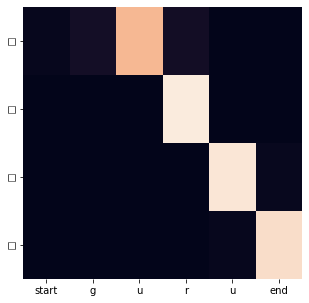

/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2986 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2997 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3007 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240:

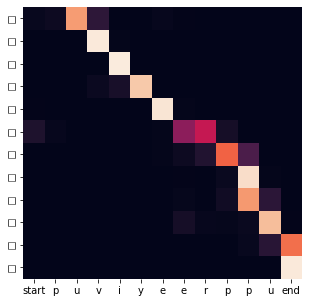

/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2975 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2985 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2990 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2980 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: R

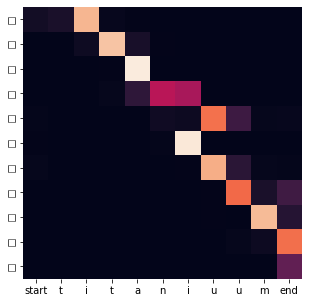

/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3006 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 3006 missing from current font.
  font.set_text(s, 0, flags=flags)


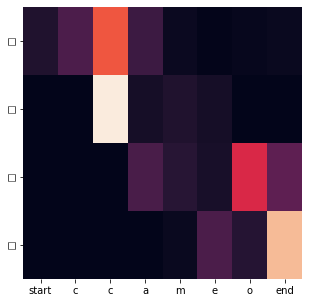

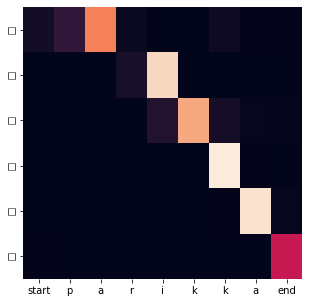

/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3019 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 3019 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2994 missing from current font.
  font.set_text(s, 0, flags=flags)


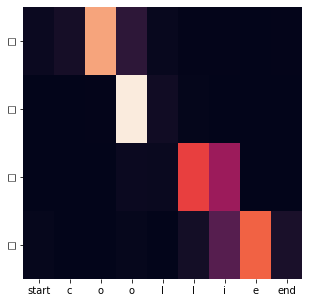

/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2984 missing from current font.
  font.set_text(s, 0, flags=flags)


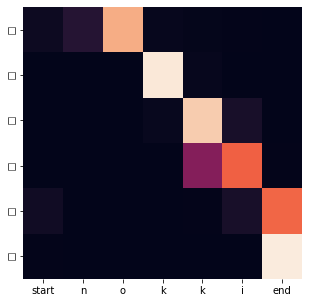

/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2949 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3001 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2949 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 3001 missing from current font.
  font.set_text(s, 0, flags=flags)


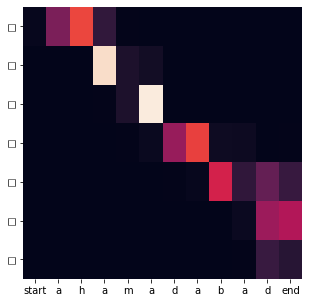

/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 3014 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 3014 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/catlab/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2979 missing from current font.
  font.set_text(s, 0, flags=flags)


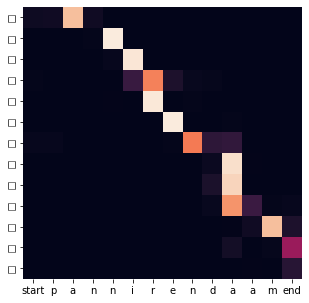

In [ ]:
def  transliterate_char(sent,attention=False,print_out=True,print_plot=False):
  sent = "\t"+sent+"\n"
  sent_vec = [seqatt.input_token_index[i] for i in sent]
  sent_vec = sequence.pad_sequences([sent_vec],maxlen=seqatt.max_length_x,padding="post")

  if attention:
      pred,attention = seqatt.evaluate_model(sent_vec[0],True)
      if print_out:
        print("Input:",sent)
        print("Output:",pred)
      
      if print_plot:
        plot_attention(attention[:len(pred),:len(sent)],sent,pred)

      return attention[:len(pred),:len(sent)],pred
      
  else:
      pred = seqatt.evaluate_model(sent_vec[0],False)
      print("Input:",sent)
      print("Output:",pred)
        
        
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as fontp

font_new =  fontp(fname='tamil.ttf')
font_dict = {'fontsize':10}

def plot_attention(attention,actual,pred):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    img = sb.heatmap(attention,cbar=False)
    ax.set_xticklabels(['start']+list(actual[1:-1])+['end'])
    ax.set_yticklabels(list(pred),fontdict=font_dict,fontproperties=font_new)
    fig.savefig("ex.png")
    temp = plt.imread("ex.png")
    plot.append(temp)
    plt.show()
import random

idxs = [i for i in range(0,5747)]
random.shuffle(idxs)
idxs = idxs[:9]
plot = []
for i in idxs:
  input = ""
  for x in seqatt.encoder_test[i][1:]:
    if seqatt.inv_input_token_index[x]=="\n":
      break
    input += seqatt.inv_input_token_index[x]

  att,pred =  transliterate_char(input,attention=True,print_out=False,print_plot=True)


wandb.log({"Attention HeatMaps": [wandb.Image(img) for img in plot]})


In [ ]:
#Attention Visualization

In [ ]:
from IPython.display import HTML as html_print
from IPython.display import display

In [ ]:
def cstr(s,flag=False, color='black'):
  if flag: 
    return "<text style=color:#000;background-color:{};font-size:31px>{} </text>".format(color, s)
    
  return "<text style=color:#000;background-color:{};font-size:30px>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) if ci != '#f42e2e' else cstr(ti,True,color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

In [ ]:
def visualize_connections(input, attention_matrix, target_char_index):
  text_colours = []

  for i in range(len(input)+2):
    if i == 0:
      text = ("/start/",get_clr(attention_matrix[target_char_index][i]))
    elif i == len(input)+1:
      text = ("/end/",get_clr(attention_matrix[target_char_index][i]))
    else:
      text = (input[i-1], get_clr(attention_matrix[target_char_index][i]))
    
    text_colours.append(text)
  print_color(text_colours)

def visualize_output(input,idx):
  text_colours = []
  for i in range(len(input)):
    
    if i==idx:
      text = (input[i],'#f42e2e')
    else:
      text = (input[i],'#85c2e1')
    text_colours.append(text)
  print_color(text_colours)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
    def  transliterate_attn(sent,attention=False,print_out=True,print_plot=False):
      sent = "\t"+sent+"\n"
      sent_vec = [seqatt.input_token_index[i] for i in sent]
      sent_vec = sequence.pad_sequences([sent_vec],maxlen=seqatt.max_length_x,padding="post")

      if attention:
          pred,attention = seqatt.evaluate_model(sent_vec[0],True)
          if print_out:
            print("Input:",sent)
            print("Output:",pred)

          if print_plot:
            attention_plot(attention[:len(pred),:len(sent)],sent,pred)

          return attention[:len(pred),:len(sent)],pred

      else:
          pred = seqatt.evaluate_model(sent_vec[0],False)
          print("Input:",sent)
          print("Output:",pred) 

In [ ]:
#word to visualisation for connectivity
input_word = 'ennachu' #@param {type:"string"}
attention_matrix,pred = transliterate_attn(input_word,attention=True,print_out=False)

def color_code(idx):
    print()
    visualize_connections(input_word,attention_matrix,idx)
    print()
    print()
    print(pred)
    visualize_output(pred,idx)

  
interact(color_code, idx=(0,len(pred)-1));

interactive(children=(IntSlider(value=2, description='idx', max=5), Output()), _dom_classes=('widget-interact'…